In [1]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
from matplotlib.colors import ListedColormap

In [2]:
os.makedirs('results', exist_ok=True)

In [6]:
def variance_reservoir(s,chi,N,gamma):
    b=(1+gamma*chi*s**2)
    R=lambda x:sum([x**k for k in range(int(N/2))])
    Ef2=1+s**2+gamma*(1+chi*s**2)*s**2*R(b)*(2+gamma*chi*s**2*R(b))
    return Ef2-1.0

def gamma_polynomial(q):
    return 1-2*q+2*q**2

def generate_qlist(B=2):
    return np.array([i/(2**B-1) for i in range(2**B)])

def theta(j,N):
    return (j+1)**N*(1-(j/(j+1))**N)

In [13]:
def rLipschitz(s,chi,N):
    return N*np.sqrt((2*s**2)*(1+chi*s**2)**N)/4


def LipschitzOrderParameter(N,srange):

    bonds=np.linspace(10,100,91)
    stds=np.linspace(srange[0],srange[1],100)
    X=np.zeros((len(bonds),len(stds)))
    Y=np.zeros((len(bonds),len(stds)))
    Z=np.zeros((len(bonds),len(stds)))

    for i in range(len(bonds)):
        bond=bonds[i]
        #print('bond=',bond)
        X[i,:]=(np.array(stds))
        Y[i,:]=bond
        Z[i,:]=np.array([rLipschitz(s,bond,N) for s in stds])

    fig,ax=plt.subplots()
    mesh=ax.pcolormesh(X,Y,Z,cmap='plasma',norm='log')

    cb=fig.colorbar(mesh)

    critical=ax.contour(X,Y,Z,[1.0],linestyles='dashed',colors='w')

    ax.set_xlabel('std $\sigma_A$', size=15)
    ax.set_ylabel('Bond dimension $\chi$', size=15)
    cb.ax.set_ylabel('$r$', size=13)

    plt.rcParams['font.sans-serif'] = ['Arial']
    plt.tick_params(labelsize=13)
    plt.ylim([10,100])
    plt.xlim(srange)
    plt.savefig('results/Figr'+str(N)+'_range'+str(srange[1])+'.pdf', bbox_inches='tight')

    return Z

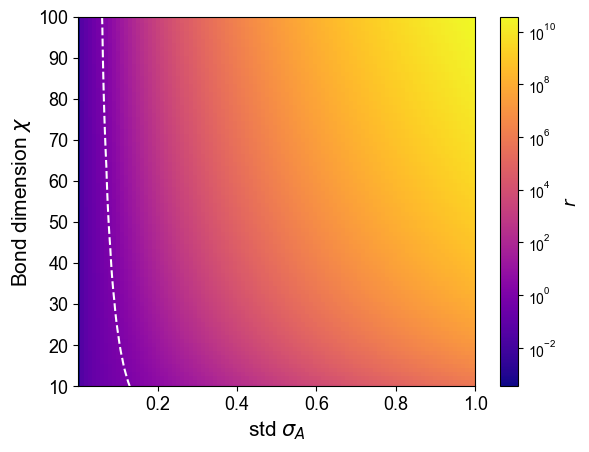

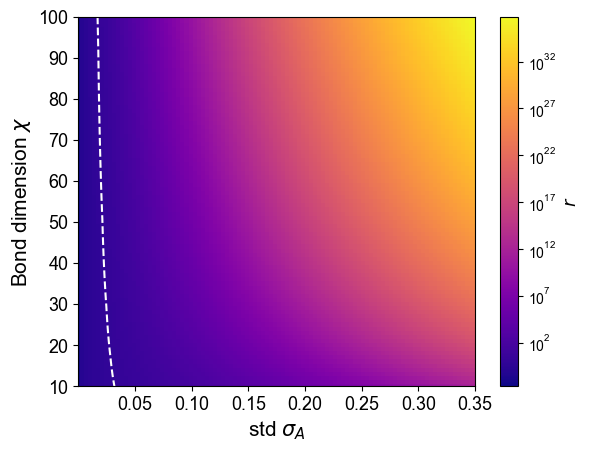

In [26]:
rN10=LipschitzOrderParameter(N=10,srange=[1e-4,1.0])
plt.savefig('results/figure_supp_3_1_a.pdf')
rN64=LipschitzOrderParameter(N=64,srange=[1e-4,0.35])

In [8]:
# mean field
from scipy.special import expit,roots_hermite
from scipy.optimize import root,minimize

def iterVariance(mux,varx,s,chi,N):
    gamma=1-2*mux+2*(varx+mux**2)
    return variance_reservoir(s,chi,N,gamma)


xgrid,weights=roots_hermite(20)
print(xgrid)
print(weights)

def GaussHermiteExpect(h,mu,var,order):
    xgrid,weights=roots_hermite(order)
    #if var<0:
    #    print('var=',var)
    return np.dot(weights,h(np.sqrt(2*np.abs(var))*xgrid+mu))/np.sqrt(np.pi)

def h(x):
    return x

print(GaussHermiteExpect(h,0.0,1.0,5),'should be zero')
print(GaussHermiteExpect(h,1.0,1.0,5),'should be one')

def recurrence(mux,varx,s,chi,N,order):
    iterVar=iterVariance(mux,varx,s,chi,N)
    mux_new=GaussHermiteExpect(expit,1.0,iterVar,order)
    sigmoid2=lambda x: (expit(x))**2
    varx_new=GaussHermiteExpect(sigmoid2,1.0,iterVar,order)-mux**2
    return mux_new,varx_new

#print(recurrence(mux=0.5,varx=0.5,s=0.1,chi=10,N=10,order=10))


def selfconsistent(muvarx,s,chi,N,order):
    mux_new,varx_new=recurrence(muvarx[0],muvarx[1],s,chi,N,order)
    return np.array([(mux_new-muvarx[0]),(varx_new-muvarx[1])])

def solvability(s,chi,N,order):
    tobesolve=lambda muvarx:selfconsistent(muvarx,s,chi,N,order)
    muvarx0=np.array([0.5,0.1])
    return root(tobesolve,muvarx0)

#print(solvability(s=0.1,chi=10,N=10,order=20))



[-5.38748089 -4.60368245 -3.94476404 -3.34785457 -2.78880606 -2.254974
 -1.73853771 -1.23407622 -0.73747373 -0.24534071  0.24534071  0.73747373
  1.23407622  1.73853771  2.254974    2.78880606  3.34785457  3.94476404
  4.60368245  5.38748089]
[2.22939365e-13 4.39934099e-10 1.08606937e-07 7.80255648e-06
 2.28338636e-04 3.24377334e-03 2.48105209e-02 1.09017206e-01
 2.86675505e-01 4.62243670e-01 4.62243670e-01 2.86675505e-01
 1.09017206e-01 2.48105209e-02 3.24377334e-03 2.28338636e-04
 7.80255648e-06 1.08606937e-07 4.39934099e-10 2.22939365e-13]
2.7403961633492392e-17 should be zero
0.9999999999999999 should be one


In [17]:
def recurrenceOrderParameter(N,srange,gqorder):

    bonds=np.linspace(10,100,91)
    stds=np.linspace(srange[0],srange[1],100)
    X=np.zeros((len(bonds),len(stds)))
    Y=np.zeros((len(bonds),len(stds)))
    Z=np.zeros((len(bonds),len(stds)))
    Z0=np.zeros((len(bonds),len(stds)))
    Z1=np.zeros((len(bonds),len(stds)))

    for i in range(len(bonds)):
        bond=bonds[i]
        #print('bond=',bond)
        X[i,:]=(np.array(stds))
        Y[i,:]=bond
        results=[solvability(s,bond,N,order=gqorder) for s in stds]
        Z[i,:]=np.array([np.sum(np.absolute(z.fun)) for z in results])
        Z0[i,:]=np.array([z.x[0] for z in results])
        Z1[i,:]=np.array([z.x[1] for z in results])


    fig,ax=plt.subplots()
    mesh=ax.pcolormesh(X,Y,Z,cmap='plasma')#,norm='symlog')

    cb=fig.colorbar(mesh)

    #critical=ax.contour(X,Y,Z,[1.0],linestyles='dashed',colors='w')

    ax.set_xlabel('std $\sigma_A$', size=15)
    ax.set_ylabel('Bond dimension $\chi$', size=15)
    cb.ax.set_ylabel('Mean-field error', size=13)

    plt.rcParams['font.sans-serif'] = ['Arial']
    plt.tick_params(labelsize=13)
    plt.ylim([10,100])
    plt.xlim(srange)
    plt.savefig('results/FigRecurrenceErr'+str(N)+'_range'+str(srange[1])+'.pdf', bbox_inches='tight')

    fig,ax=plt.subplots()
    mesh=ax.pcolormesh(X,Y,Z0,cmap='plasma')

    cb=fig.colorbar(mesh)

    #critical=ax.contour(X,Y,Z,[0],linestyles='dashed',colors='w')

    ax.set_xlabel('std $\sigma_A$', size=15)
    ax.set_ylabel('Bond dimension $\chi$', size=15)
    cb.ax.set_ylabel('Mean-field $\mu_x$', size=13)

    plt.rcParams['font.sans-serif'] = ['Arial']
    plt.tick_params(labelsize=13)
    plt.ylim([10,100])
    plt.xlim(srange)
    plt.savefig('results/FigRecurrenceMean'+str(N)+'_range'+str(srange[1])+'.pdf', bbox_inches='tight')

    fig,ax=plt.subplots()
    mesh=ax.pcolormesh(X,Y,Z1,cmap='plasma')

    cb=fig.colorbar(mesh)

    critical=ax.contour(X,Y,Z1,[0.125],linestyles='dashed',colors='w')

    ax.set_xlabel('std $\sigma_A$', size=15)
    ax.set_ylabel('Bond dimension $\chi$', size=15)
    cb.ax.set_ylabel('Mean-field $v_x$', size=13)

    plt.rcParams['font.sans-serif'] = ['Arial']
    plt.tick_params(labelsize=13)
    plt.ylim([10,100])
    plt.xlim(srange)
    plt.savefig('results/FigRecurrenceVar'+str(N)+'_range'+str(srange[1])+'.pdf', bbox_inches='tight')

    return Z,Z0,Z1

/tmp/ipykernel_24159/19218230.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax=plt.subplots()


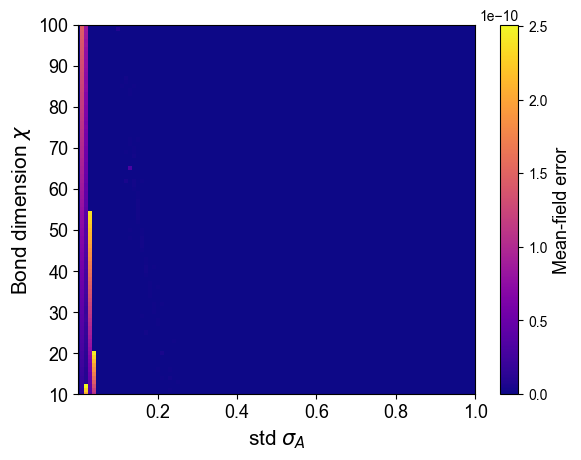

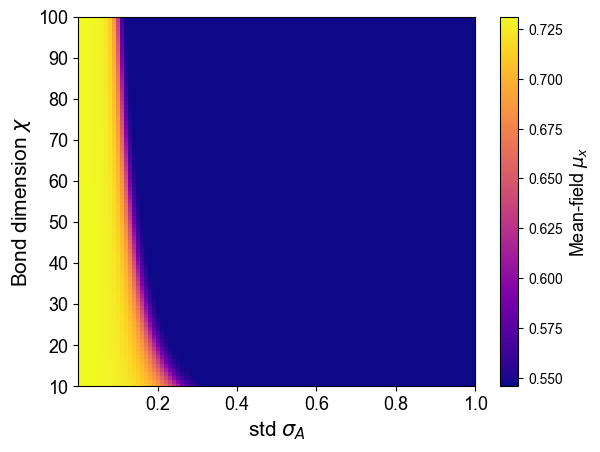

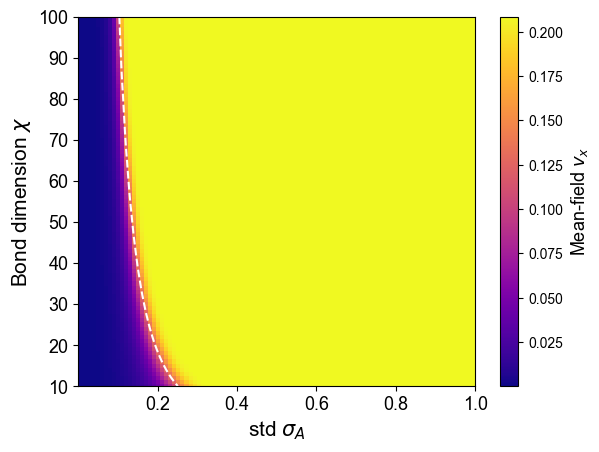

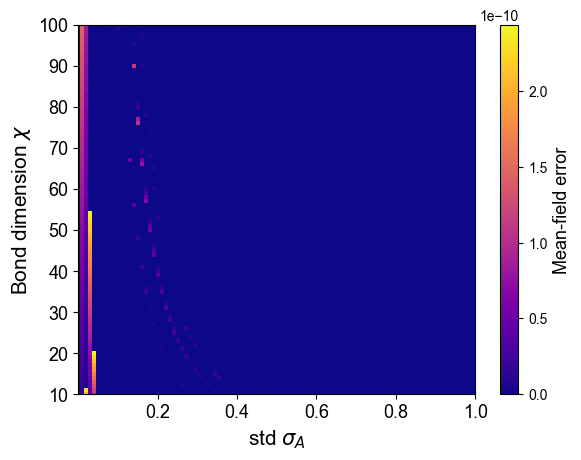

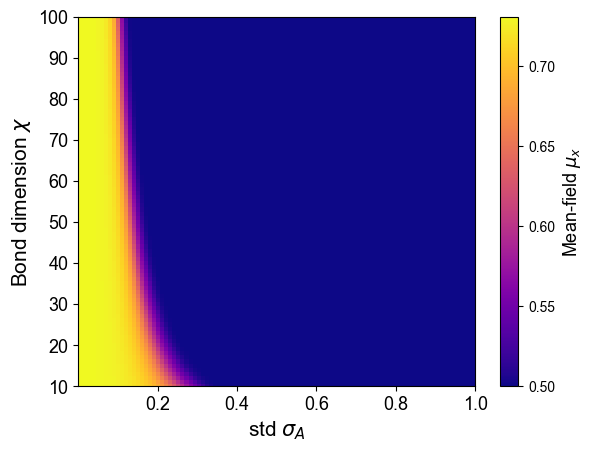

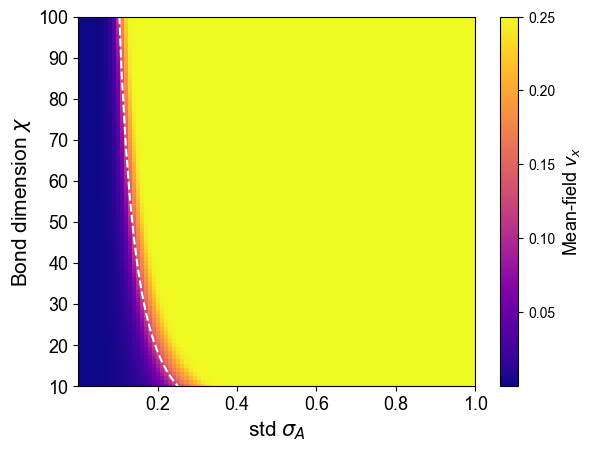

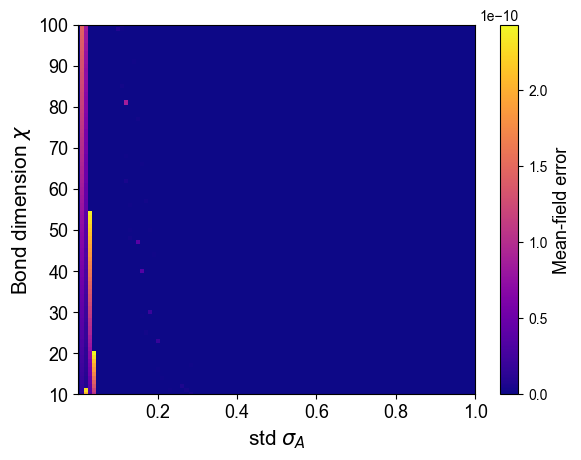

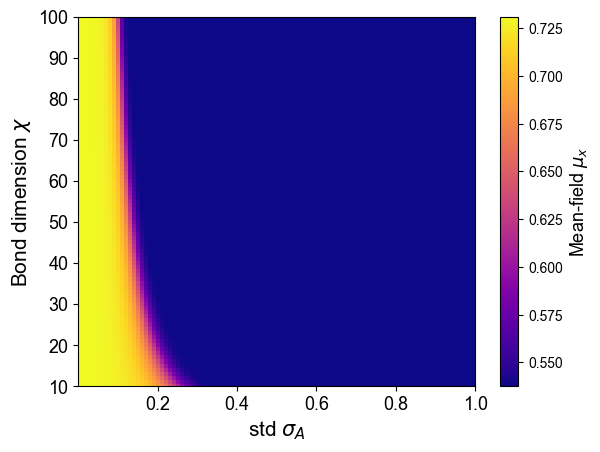

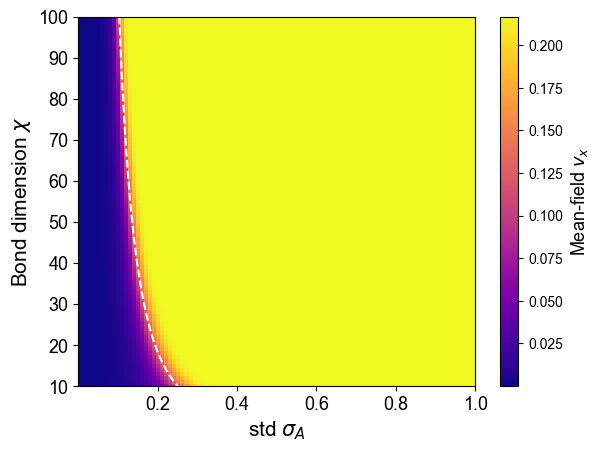

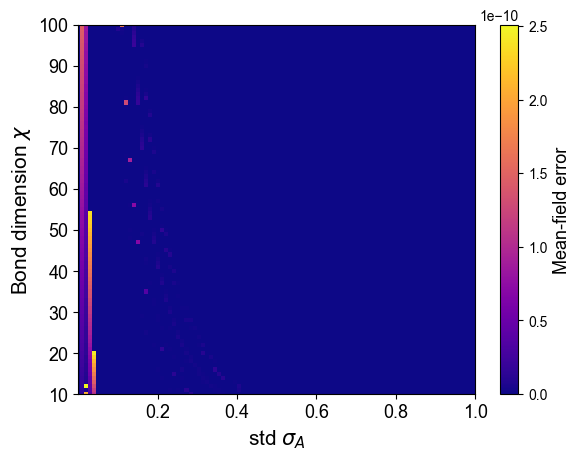

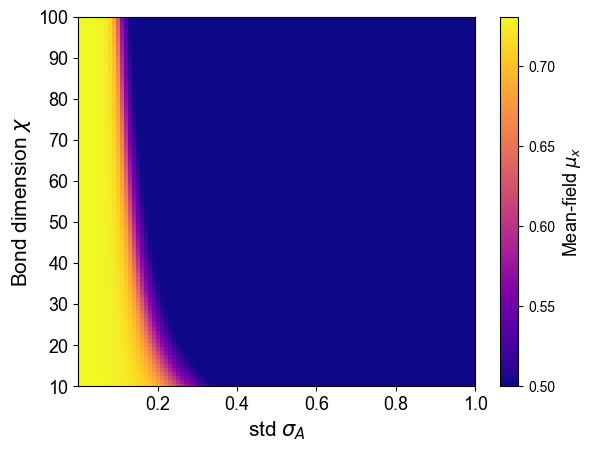

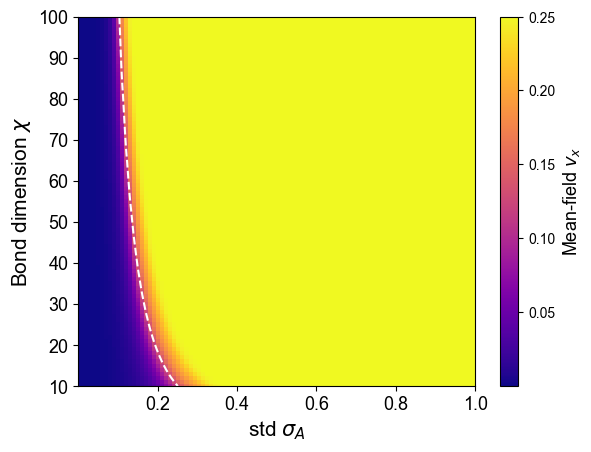

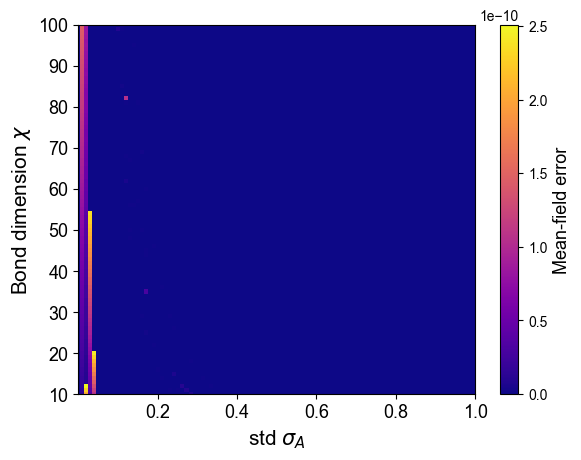

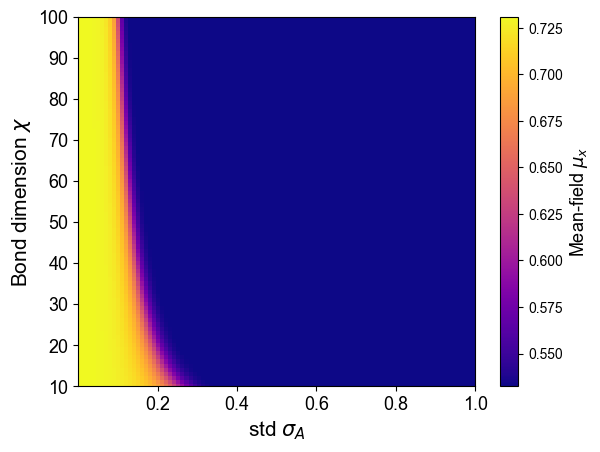

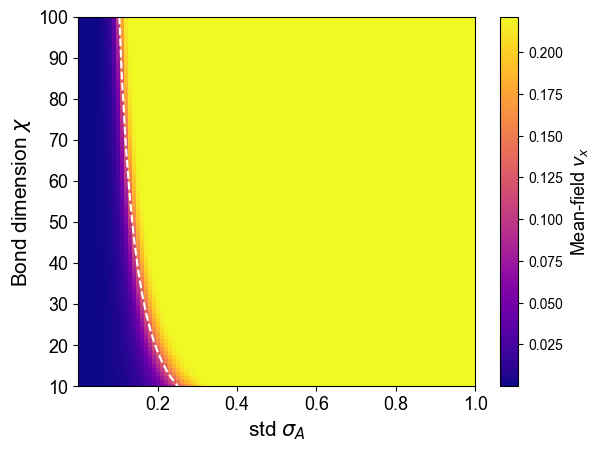

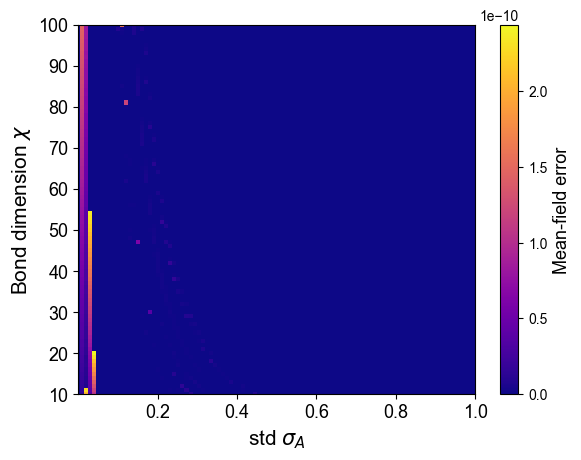

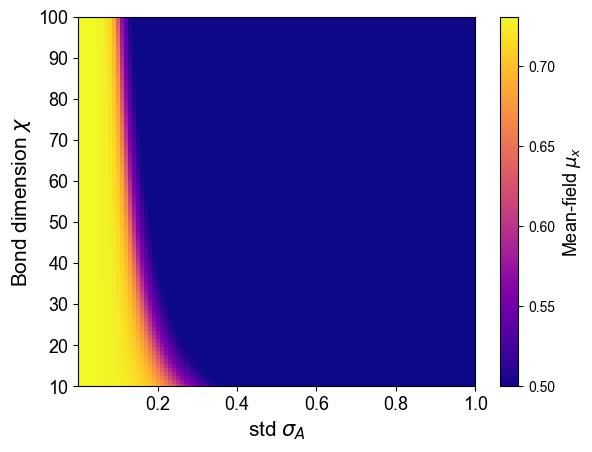

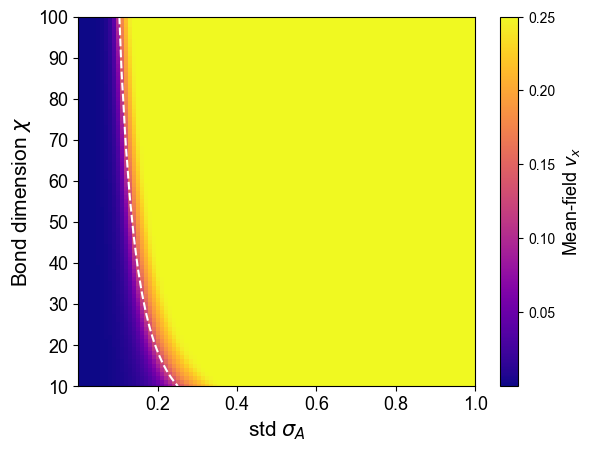

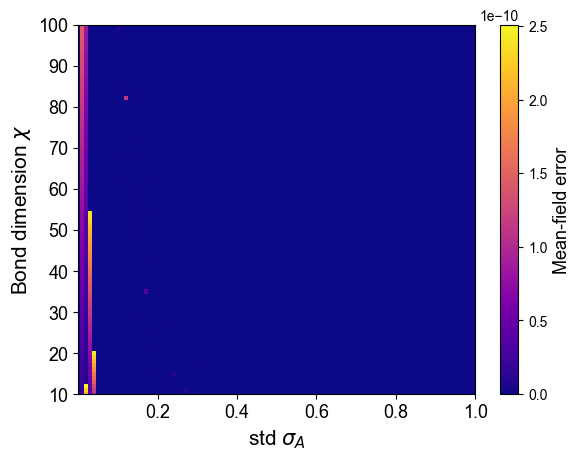

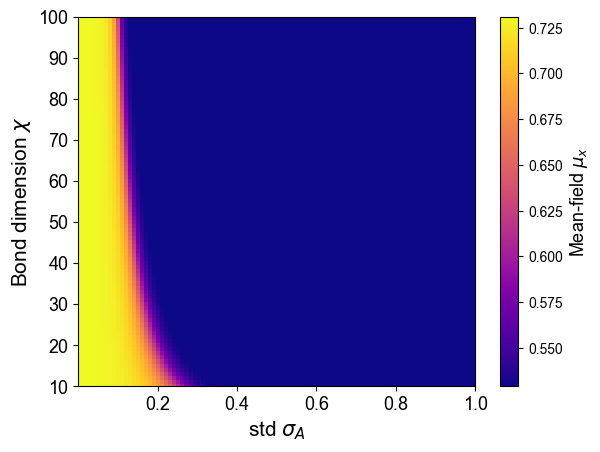

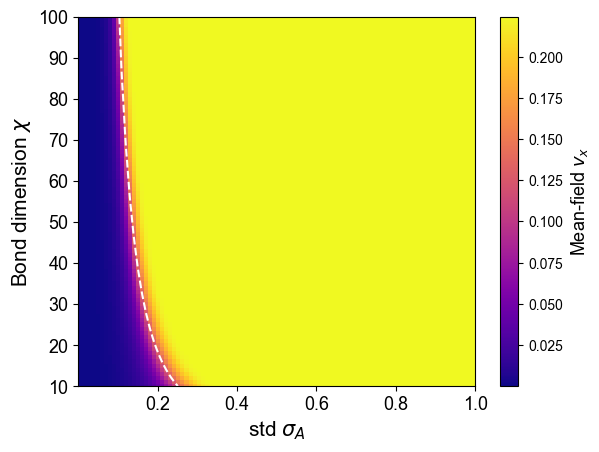

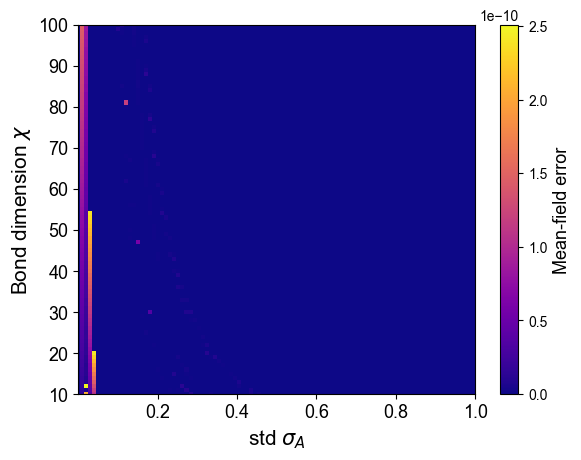

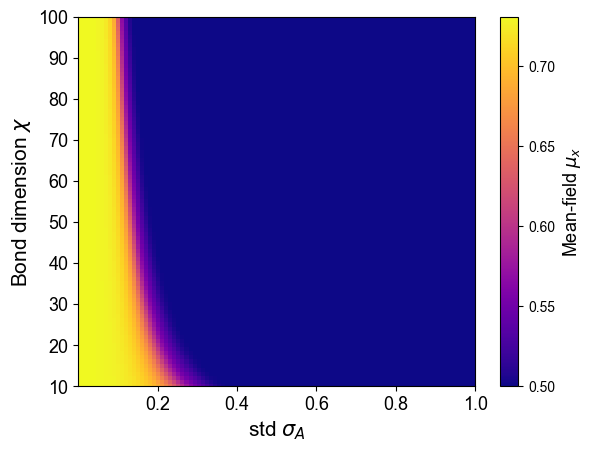

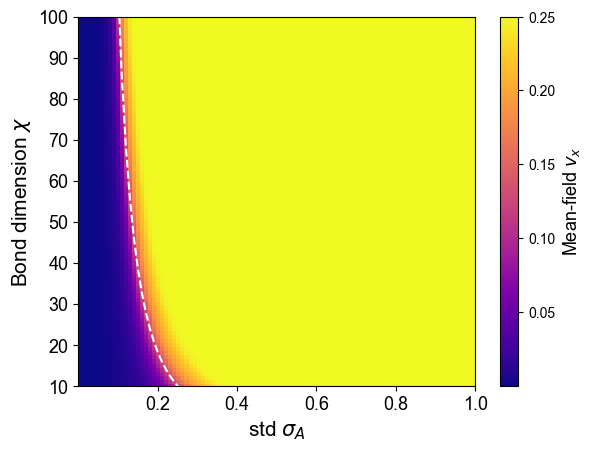

In [18]:
orderlist=np.array([39,40,59,60,79,80,99,100])
convcheck=np.zeros(len(orderlist))

for i in range(len(orderlist)):
    MFer10,MFm10,MFv10=recurrenceOrderParameter(N=10,srange=[1e-4,1.0],gqorder=orderlist[i])
    convcheck[i]=MFm10[-1,-1]


In [27]:
shutil.copyfile('results/FigRecurrenceMean10_range1.0.pdf', 'results/figure_supp_3_1_b.pdf')
shutil.copyfile('results/FigRecurrenceVar10_range1.0.pdf', 'results/figure_supp_3_1_c.pdf')

'results/figure_supp_3_1_c.pdf'

In [22]:
print(MFm10)
print(MFv10)
print(expit(1))

[[0.73105858 0.73102507 0.73092462 ... 0.5        0.5        0.5       ]
 [0.73105858 0.73102506 0.73092444 ... 0.5        0.5        0.5       ]
 [0.73105858 0.73102505 0.73092426 ... 0.5        0.5        0.5       ]
 ...
 [0.73105858 0.73102407 0.7309079  ... 0.5        0.5        0.5       ]
 [0.73105858 0.73102406 0.73090769 ... 0.5        0.5        0.5       ]
 [0.73105858 0.73102405 0.73090749 ... 0.5        0.5        0.5       ]]
[[2.73213318e-09 2.85195325e-05 1.14078675e-04 ... 2.50000000e-01
  2.50000000e-01 2.50000000e-01]
 [2.73213318e-09 2.85290451e-05 1.14229556e-04 ... 2.50000000e-01
  2.50000000e-01 2.50000000e-01]
 [2.73213270e-09 2.85385615e-05 1.14381119e-04 ... 2.50000000e-01
  2.50000000e-01 2.50000000e-01]
 ...
 [2.73214030e-09 2.93713363e-05 1.28330541e-04 ... 2.50000000e-01
  2.50000000e-01 2.50000000e-01]
 [2.73214329e-09 2.93811887e-05 1.28504145e-04 ... 2.50000000e-01
  2.50000000e-01 2.50000000e-01]
 [2.73214063e-09 2.93910451e-05 1.28678022e-04 ... 2.500

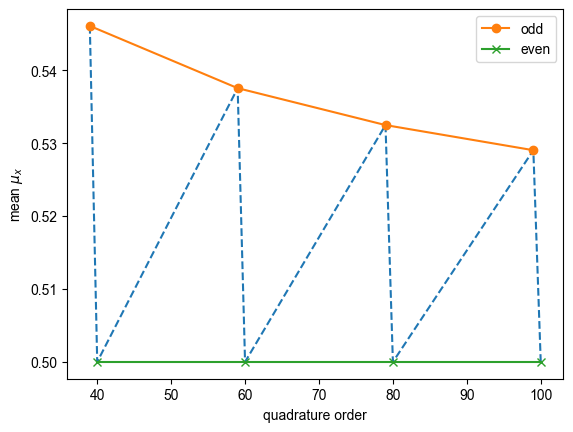

In [24]:
plt.plot(orderlist,convcheck,'--')
plt.plot(orderlist[0::2],convcheck[0::2],'o-',label='odd')
plt.plot(orderlist[1::2],convcheck[1::2],'x-',label='even')
plt.legend()
plt.xlabel('quadrature order')
plt.ylabel('mean $\mu_x$')
plt.savefig('results/figure_supp_3_2.pdf', bbox_inches='tight')

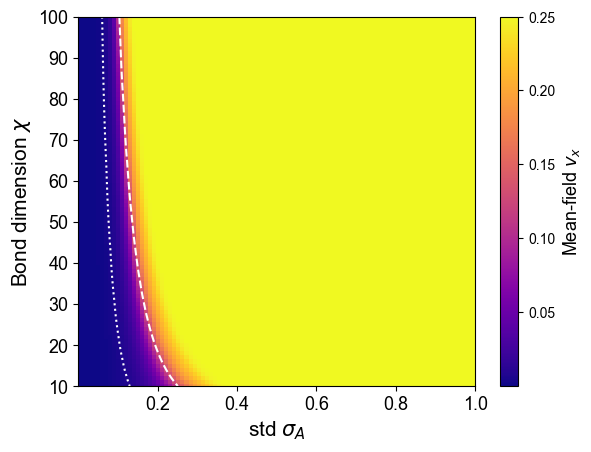

In [34]:
bonds=np.linspace(10,100,91)
stds=np.linspace(1e-4,1.0,100)
X=np.zeros((len(bonds),len(stds)))
Y=np.zeros((len(bonds),len(stds)))

for i in range(len(bonds)):
    bond=bonds[i]
    X[i,:]=(np.array(stds))
    Y[i,:]=bond

fig,ax=plt.subplots()
mesh=ax.pcolormesh(X,Y,MFv10,cmap='plasma')
cb=fig.colorbar(mesh)

criticalv=ax.contour(X,Y,MFv10,[0.125],linestyles='dashed',colors='w')
criticalr=ax.contour(X,Y,rN10,[1.0],linestyles='dotted',colors='w')



ax.set_xlabel('std $\sigma_A$', size=15)
ax.set_ylabel('Bond dimension $\chi$', size=15)
cb.ax.set_ylabel('Mean-field $v_x$', size=13)

plt.rcParams['font.sans-serif'] = ['Arial']
plt.tick_params(labelsize=13)
plt.ylim([10,100])
plt.xlim([1e-4,1.0])
plt.savefig('results/figure_supp_3_1_d.pdf', bbox_inches='tight')
plt.savefig('results/figure_supp_5_b.pdf', bbox_inches='tight')

np.savez('results/Order_parameter_10.npz', X=X, Y=Y, Mfv10=MFv10, rN10=rN10)

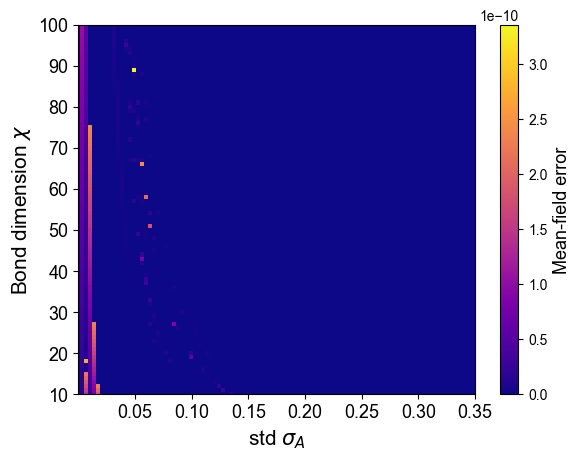

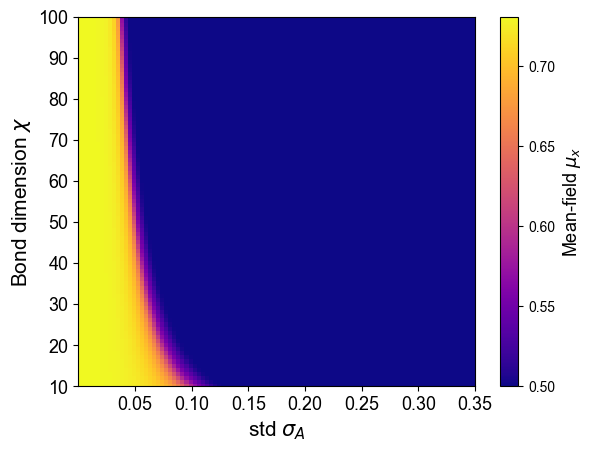

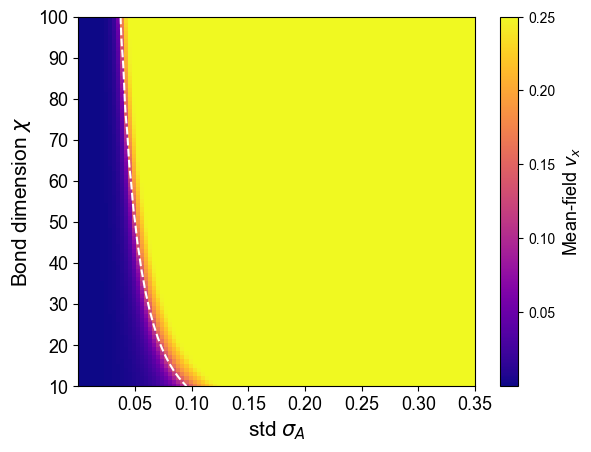

In [29]:
MFer64,MFm64,MFv64=recurrenceOrderParameter(N=64,srange=[1e-4,0.35],gqorder=100)

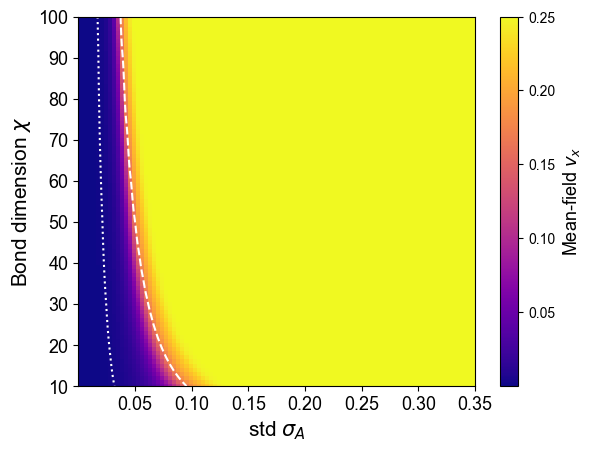

In [35]:
bonds=np.linspace(10,100,91)
stds=np.linspace(1e-4,0.35,100)
X=np.zeros((len(bonds),len(stds)))
Y=np.zeros((len(bonds),len(stds)))

for i in range(len(bonds)):
    bond=bonds[i]
    X[i,:]=(np.array(stds))
    Y[i,:]=bond

fig,ax=plt.subplots()
mesh=ax.pcolormesh(X,Y,MFv10,cmap='plasma')
cb=fig.colorbar(mesh)

criticalv=ax.contour(X,Y,MFv64,[0.125],linestyles='dashed',colors='w')
criticalr=ax.contour(X,Y,rN64,[1.0],linestyles='dotted',colors='w')



ax.set_xlabel('std $\sigma_A$', size=15)
ax.set_ylabel('Bond dimension $\chi$', size=15)
cb.ax.set_ylabel('Mean-field $v_x$', size=13)

plt.rcParams['font.sans-serif'] = ['Arial']
plt.tick_params(labelsize=13)
plt.ylim([10,100])
plt.xlim([1e-4,0.35])
plt.savefig('results/figure_5_d.pdf', bbox_inches='tight')
np.savez('results/Order_parameter_64.npz', X=X, Y=Y, Mfv64=MFv64, rN64=rN64)

In [11]:
# Binary input Rademacher complexity feature variance
def Kernel(s,chi,N,L,gamma,order):
    Var=variance_reservoir(s,chi,N,gamma)
    sigmoid2=lambda x: (expit(x))**2
    return L*(GaussHermiteExpect(sigmoid2,1.0,Var,order)-GaussHermiteExpect(expit,1.0,Var,order)**2)


def RadOrderParameter(N,srange,gamma):

    L=1000
    order=100

    bonds=np.linspace(10,100,91)
    stds=np.linspace(srange[0],srange[1],100)
    X=np.zeros((len(bonds),len(stds)))
    Y=np.zeros((len(bonds),len(stds)))
    Z=np.zeros((len(bonds),len(stds)))

    for i in range(len(bonds)):
        bond=bonds[i]
        #print('bond=',bond)
        X[i,:]=(np.array(stds))
        Y[i,:]=bond
        Z[i,:]=[Kernel(s,bond,N,L,gamma,order) for s in stds]

    fig,ax=plt.subplots()
    mesh=ax.pcolormesh(X,Y,Z,cmap='plasma')#,norm='symlog')

    cb=fig.colorbar(mesh)

    critical=ax.contour(X,Y,Z,[125],linestyles='dashed',colors='w')

    ax.set_xlabel('std $\sigma_A$', size=15)
    ax.set_ylabel('Bond dimension $\chi$', size=15)
    cb.ax.set_ylabel('$\Gamma$', size=13)

    plt.rcParams['font.sans-serif'] = ['Arial']
    plt.tick_params(labelsize=13)
    plt.ylim([10,100])
    plt.xlim(srange)
    plt.savefig('FigKernel'+str(N)+'_range'+str(srange[1])+'gamma'+str(gamma)+'.pdf', bbox_inches='tight')

    return X,Y,Z


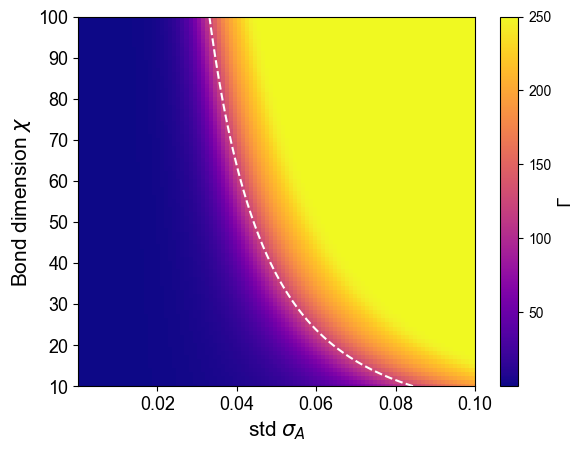

In [16]:
X, Y, Z=RadOrderParameter(N=64,srange=[1e-4,0.1],gamma=1.0)
plt.savefig('results/figure_4_d.pdf', bbox_inches='tight')
np.savez('results/RadOrderParameter.npz', X=X, Y=Y, Z=Z)

In [2]:
# load order parameter
save_array = np.load('results/Order_parameter_64.npz')
X1 = save_array['X']
Y1 = save_array['Y']
MFv64 = save_array['Mfv64']

[[3.73983227e-02 1.00000000e+02]
 [3.75116787e-02 9.90000000e+01]
 [3.76340926e-02 9.80000000e+01]
 [3.77684202e-02 9.70000000e+01]
 [3.79179233e-02 9.60000000e+01]
 [3.80863021e-02 9.50000000e+01]
 [3.82776352e-02 9.40000000e+01]
 [3.84961917e-02 9.30000000e+01]
 [3.87461128e-02 9.20000000e+01]
 [3.89777778e-02 9.11775748e+01]
 [3.90299657e-02 9.10000000e+01]
 [3.93049251e-02 9.00000000e+01]
 [3.95489675e-02 8.90000000e+01]
 [3.97655131e-02 8.80000000e+01]
 [3.99589725e-02 8.70000000e+01]
 [4.01341796e-02 8.60000000e+01]
 [4.02960116e-02 8.50000000e+01]
 [4.04491980e-02 8.40000000e+01]
 [4.05982822e-02 8.30000000e+01]
 [4.07476880e-02 8.20000000e+01]
 [4.09018605e-02 8.10000000e+01]
 [4.10654591e-02 8.00000000e+01]
 [4.12435722e-02 7.90000000e+01]
 [4.14418966e-02 7.80000000e+01]
 [4.16667915e-02 7.70000000e+01]
 [4.19251081e-02 7.60000000e+01]
 [4.22237410e-02 7.50000000e+01]
 [4.25121212e-02 7.41552910e+01]
 [4.25677261e-02 7.40000000e+01]
 [4.29001478e-02 7.30000000e+01]
 [4.319211

/tmp/ipykernel_159813/2706562922.py:4: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for collection in criticalv.collections:


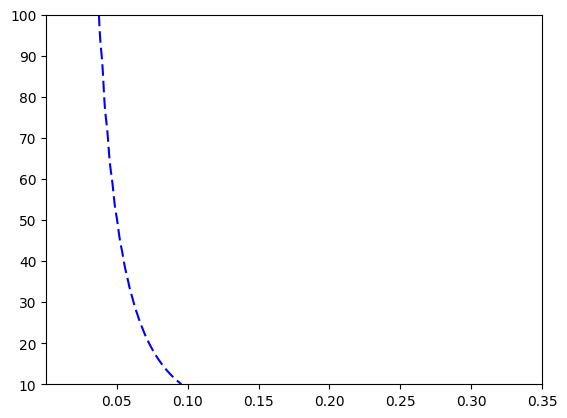

In [ ]:
criticalv=plt.contour(X1,Y1,MFv64,[0.125],linestyles='dashed',colors='b')
# Process for obtaining the vertices of a line.
contour_lines = []
for collection in criticalv.collections:
    for path in collection.get_paths():
        vertices = path.vertices  # Get the coordinates of the vertex.
        contour_lines.append(vertices)

contour_array = [np.array(line) for line in contour_lines]

for line in contour_array:
    print(line)

In [6]:
np.save('results/orderline_64.npy', contour_array)